# Exploratory Data Analysis
Following the Kaggle notebook

In [3]:
import time
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_pickle('../data/flight_delays.pkl')

In [5]:
df.head().T

,0,1,2,3,4
YEAR,2018,2018,2018,2018,2018
QUARTER,1,1,1,1,1
MONTH,1,1,1,1,1
DAY_OF_MONTH,1,1,2,2,3
DAY_OF_WEEK,1,1,2,2,3
FL_DATE,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00
CARRIER,9E,9E,9E,9E,9E
FL_NUM,3331,3940,3409,3940,3353
ROUTE,42,42,42,42,42
ORIGIN,ABY,ABY,ABY,ABY,ABY


In [6]:
airports = pd.read_csv('../data/Airports.csv')

In [7]:
airports.head()

,Airport,City_State,State
0,ABE,"Allentown/Bethlehem/Easton, PA",PA
1,ABI,"Abilene, TX",TX
2,ABQ,"Albuquerque, NM",NM
3,ABR,"Aberdeen, SD",SD
4,ABY,"Albany, GA",GA


In [8]:
airfares = pd.read_csv('../data/AirFares.csv')

In [9]:
airfares.head()

,Year,quarter,Origin,Origin_State,Dest,Dest_State,nsmiles,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low
0,2018,1,ABE,PA,ATL,GA,692,286.40,DL,0.9455,287.18,AA,0.0339,263.31
1,2018,1,ABE,PA,BNA,TN,685,234.59,AA,0.5686,227.73,AA,0.5686,227.73
2,2018,1,ABE,PA,CLT,NC,481,289.19,AA,0.9518,288.46,AA,0.9518,288.46
3,2018,1,ABE,PA,DEN,CO,1539,263.12,UA,0.4737,255.18,UA,0.4737,255.18
4,2018,1,ABE,PA,DFW,TX,1307,261.68,AA,0.6448,260.94,UA,0.1081,200.66


In [10]:
print("Number of airports: {}".format(airports.shape[0]))

Number of airports: 362


In [11]:
routes = pd.read_csv('../data/Routes.csv')

In [12]:
routes.head()

,Route,ORIGIN,ORIGIN_City_State,Origin_City,Origin_State,DEST,Dest_City_State,Dest_City,Dest_State,DISTANCE
0,1,ABE,"Allentown/Bethlehem/Easton, PA",Allentown/Bethlehem/Easton,PA,ATL,"Atlanta, GA",Atlanta,GA,692
1,2,ABE,"Allentown/Bethlehem/Easton, PA",Allentown/Bethlehem/Easton,PA,BNA,"Nashville, TN",Nashville,TN,685
2,3,ABE,"Allentown/Bethlehem/Easton, PA",Allentown/Bethlehem/Easton,PA,CLT,"Charlotte, NC",Charlotte,NC,481
3,4,ABE,"Allentown/Bethlehem/Easton, PA",Allentown/Bethlehem/Easton,PA,DTW,"Detroit, MI",Detroit,MI,425
4,5,ABE,"Allentown/Bethlehem/Easton, PA",Allentown/Bethlehem/Easton,PA,FLL,"Fort Lauderdale, FL",Fort Lauderdale,FL,1041


In [13]:
print("Number of routes: {}".format(routes.shape[0]))

Number of routes: 6684


## Comparing Airlines
**1. Comparing airlines by their punctuality**

In [14]:
df['DEP_DELAY'] = df['DEP_DELAY'].replace(-9999, np.nan)

In [15]:
print("Number of unique flight numbers: ", df['FL_NUM'].nunique())

Number of unique flight numbers:  7148


In [16]:
print("Number of unique carriers: ", df['CARRIER'].nunique())

Number of unique carriers:  17


In [17]:
def get_stats(group):
    """ Extracts the stastistical parameters from a groupby object
    """
    return {'min': group.min(), 'max': group.max(),
           'count': group.count(), 'mean': group.mean(),
           'median': group.median()}

## Adjusted Departure Delay

In [32]:
df['DEP_DELAY_NEW'] = df['DEP_DELAY_NEW'].replace(-9999, np.nan)

In [33]:
global_stats = df['DEP_DELAY_NEW'].groupby(df['CARRIER']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,median,min
CARRIER,,,,,
HA,125962.0,2482.0,5.009511,0.0,0.0
G4,149301.0,1528.0,16.147943,0.0,0.0
F9,179724.0,1254.0,21.878386,0.0,0.0
EV,261425.0,1839.0,18.272177,0.0,0.0
NK,271763.0,1527.0,14.032576,0.0,0.0
YV,317331.0,2209.0,15.655297,0.0,0.0
9E,357702.0,1659.0,15.319691,0.0,0.0
AS,370854.0,1117.0,8.455349,0.0,0.0
OH,405872.0,1157.0,14.699666,0.0,0.0


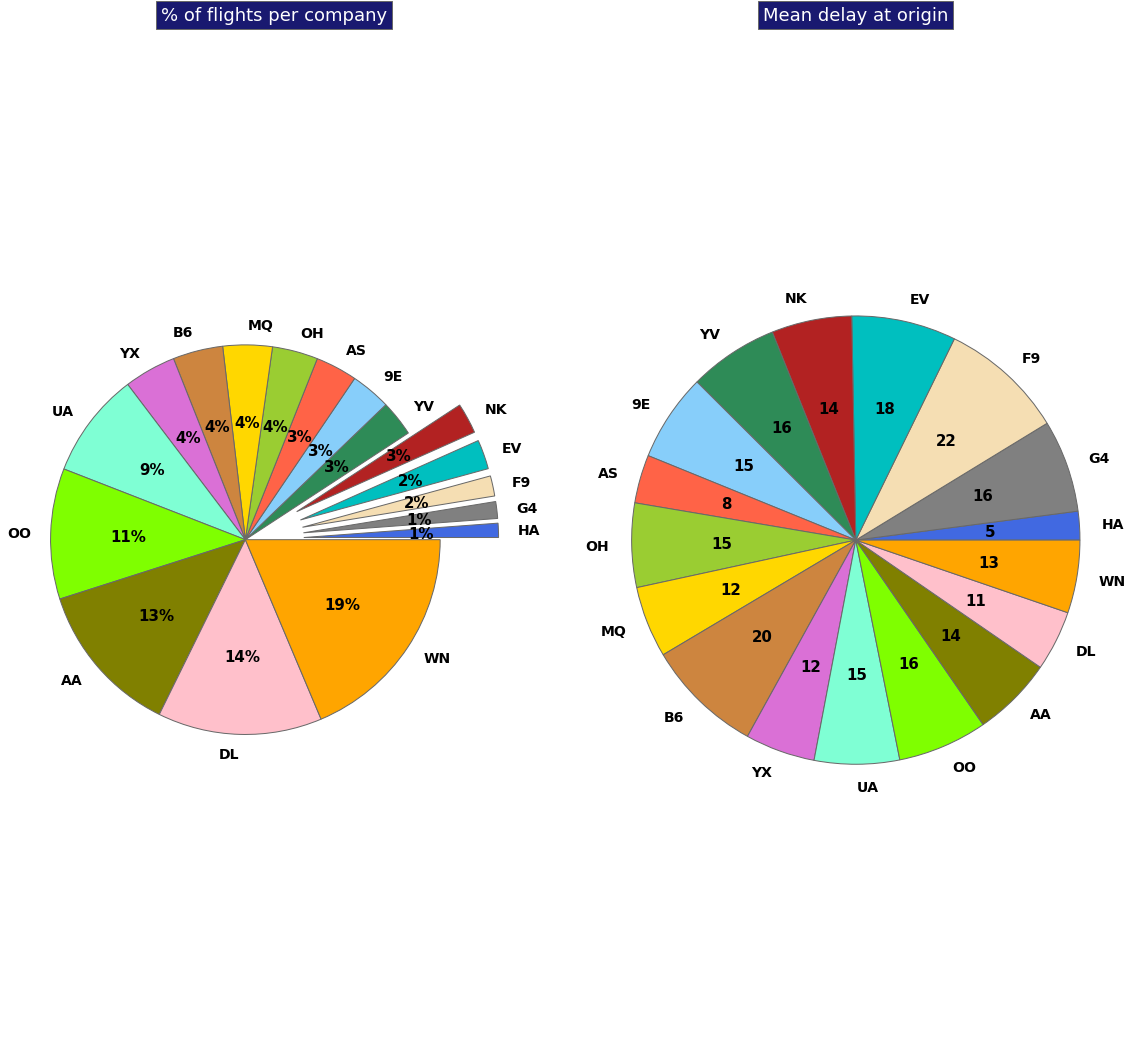

In [42]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
abbr_companies = df['CARRIER'].unique()
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['CARRIER', 'DEP_DELAY_NEW']]
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'tomato', 'yellowgreen', 'gold', 'peru', 'orchid', 'aquamarine', 'chartreuse',
          'olive', 'pink', 'orange']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(1,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1])
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 300000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = abbr_companies[i]))
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.3 if sizes[i] < 5 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
plt.tight_layout(w_pad=3)

The 1st pie chart shows that there's some disparity between the percentage of flights per airline. `WN` accounts for almost ~20% of the flights which is similar to the percentage of flights run by the 7 tiniest airlines in total.  

The 2nd pie chart shows that the differences in mean delays between the flights is less pronounced. `HA` and `AS` have low (<10 min) mean delays. `F9` and `B6` show high mean delay (>20 min) even though they occupy a tiny portion of the total air-traffic.  

## Short delays

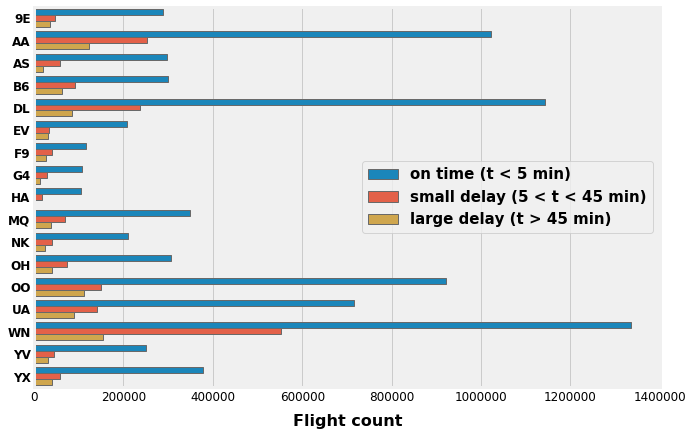

In [43]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEP_DELAY_NEW'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="CARRIER", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = abbr_companies
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

Independent of the airline,delays > 45 only constitute a small portion of the total number of delays.  

`WN`: has high proportion of small delays  
`OO`: has high proportaion of large delays

## Delays Distribution

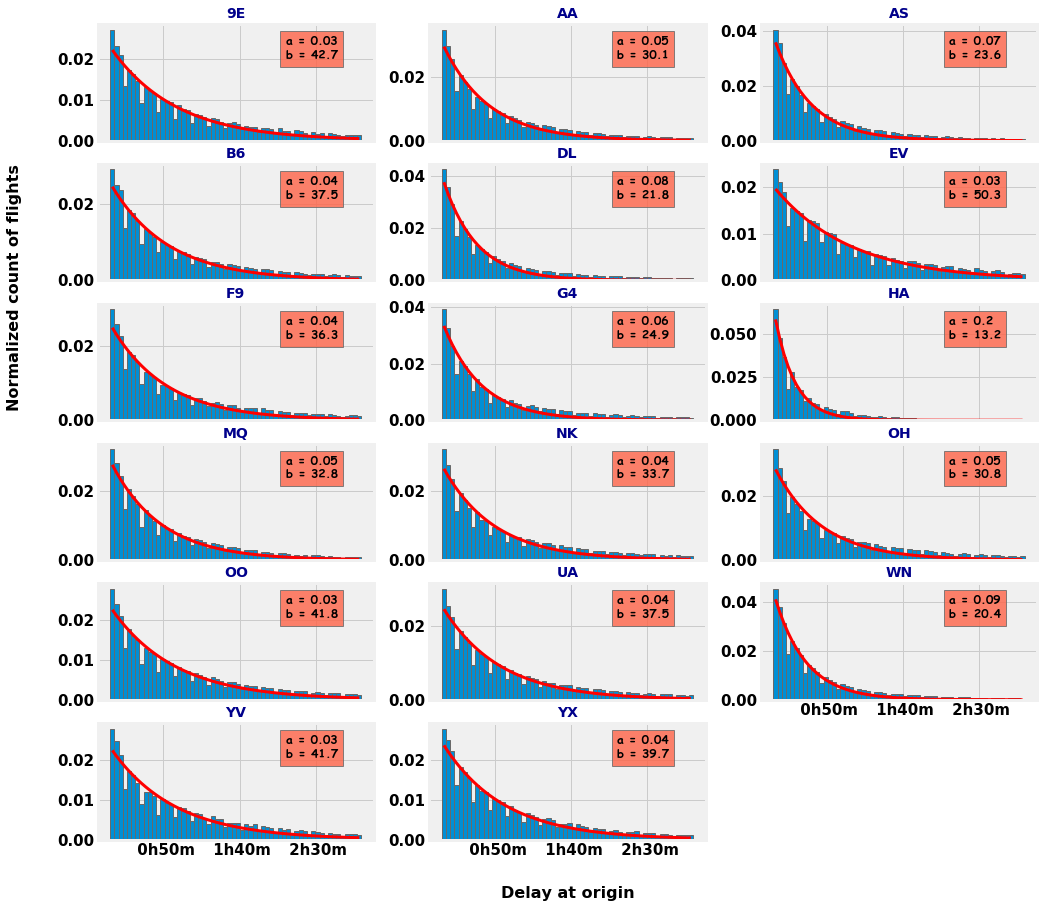

In [52]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(15,15))
i = 0
for carrier_name in abbr_companies:
    i += 1
    ax = fig.add_subplot(6,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['CARRIER'] == carrier_name]['DEP_DELAY_NEW'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 15:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 17:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
# plt.tight_layout()

The exponential curve fitting allows us to categorize airlines on the basis of their punctuality. Low values of `a` will correspond to airlines with a large proportion of delays.

In [63]:
label_company

['9E',
 'AA',
 'AS',
 'B6',
 'DL',
 'EV',
 'F9',
 'G4',
 'HA',
 'MQ',
 'NK',
 'OH',
 'OO',
 'UA',
 'WN',
 'YV',
 'YX']

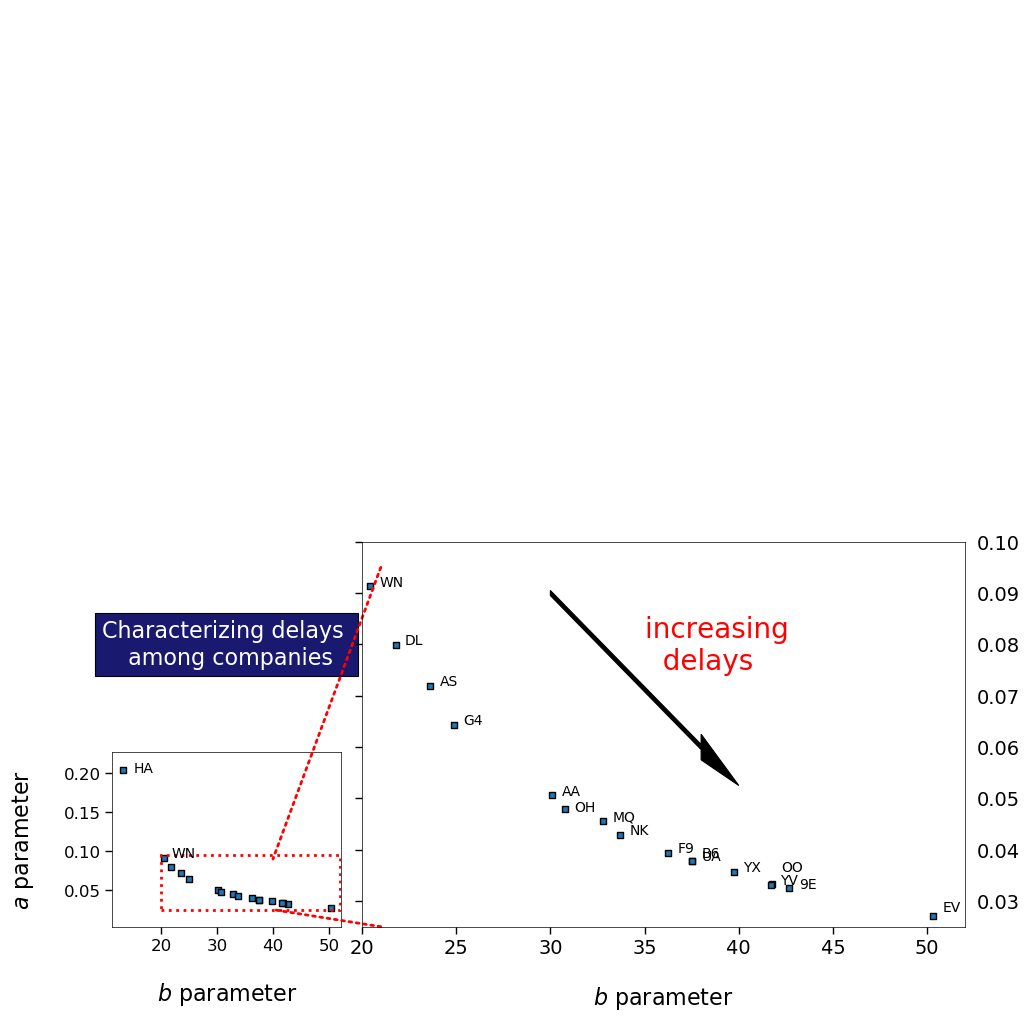

In [67]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(17)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2]) 
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
#__________________________________
# Company label: HA
i= 8
ax1.annotate(label_company[i], xy=(x_val[i]+2.0, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: DL
i= 14
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#____________
# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((20,0.025), 32, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(20,52)
ax2.set_ylim(0.025,0.1)
#________________
# Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()

`EV`: is the worst carrier since it has the worst `a` value and also from the pie chart we can see that it has a mean delay of 18 mins.
`WN`: is the carrier that has the maximum portion of number of flights (19%). At the same time it also sits 2nd in the delays plot which shows that it is also quite punctual. This could be the reason why it the most frequently used airlines. We will look into the portion of passengers it carries, its fares and the revenue it generates later.

## Relation between origin airport and delays

In [68]:
print("Number of airports: ", airports.shape[0])

Number of airports:  362


**1. Geographical area covered by airlines**
Number of destination airports for each airline.

In [69]:
origin_nb = dict()
for carrier in abbr_companies:
    liste_origin_airport = df[df['CARRIER'] == carrier]['ORIGIN'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

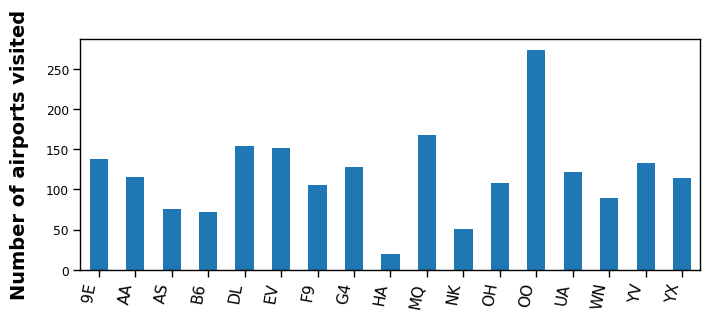

In [70]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = abbr_companies
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

**2. How the origin airport impact delays**

In [71]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies:
    df1 = df[df['CARRIER'] == carrier]
    test = df1['DEP_DELAY_NEW'].groupby(df['ORIGIN']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']

In [74]:
identify_airport = airports.set_index('Airport')['City_State'].to_dict()

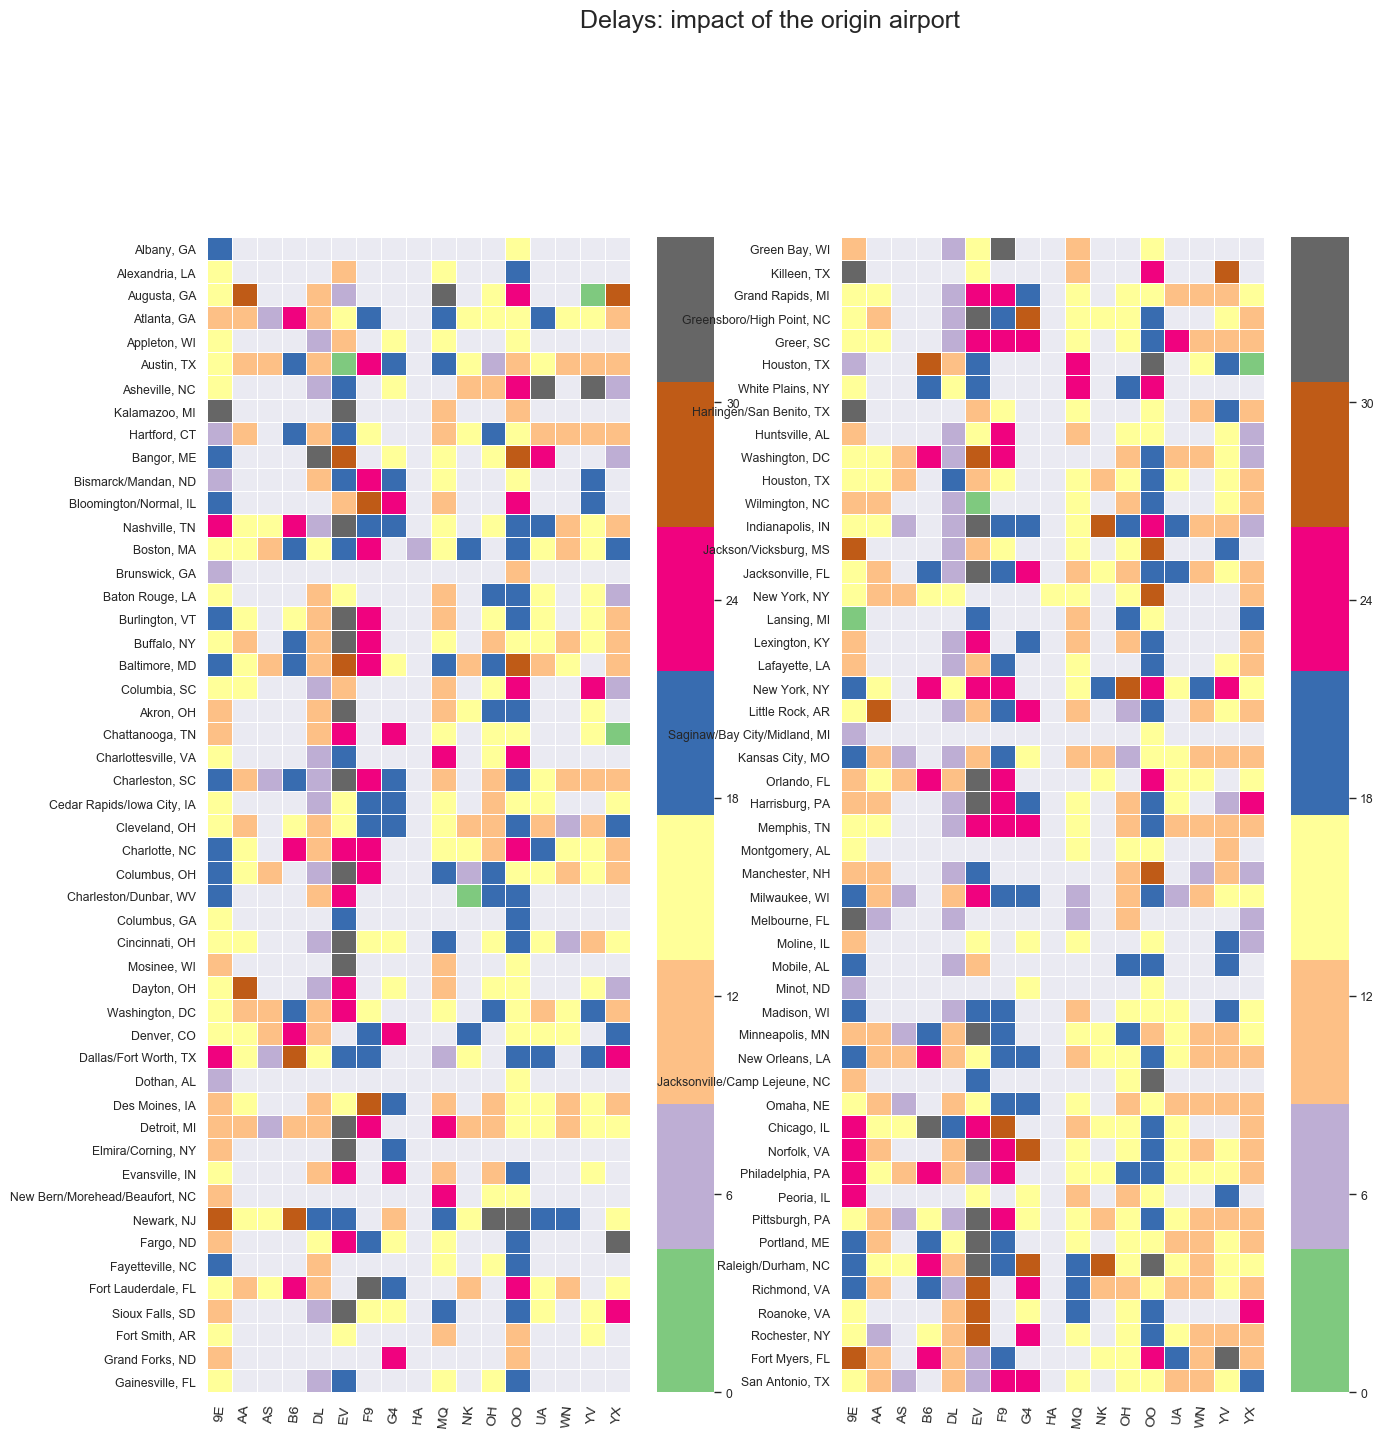

In [84]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(15,15))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:]
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:]
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

# plt.tight_layout()

`EV`: Usually has delays at a lot of airports  
`DL`: Usually has less number of delays  

We can deduce from the plots above that there is a high variability in the average delays, both between different aiports and different airlines. So it will be necessary to adopt a model that is *specific to the airline and the airport of origin*.  

## TODO
- Using external data check
    - effect of weather
    - location (using coordinates)
    
**3. Flight delays between 2 airports for a particular airlines**  
The objective here is to see if some flights are systematically delayed or if, there are flights that would be always on time.

In [85]:
#_________________________________________________________________
# We select the company and create a subset of the main dataframe
carrier = 'AA'
df1 = df[df['CARRIER']==carrier][['ORIGIN','DEST','DEP_DELAY_NEW']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if col['DEP_DELAY_NEW'] == -9999: continue
    route = str(col['ORIGIN'])+'-'+str(col['DEST'])
    if route in trajet.keys():
        trajet[route].append(col['DEP_DELAY_NEW'])
    else:
        trajet[route] = [col['DEP_DELAY_NEW']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()

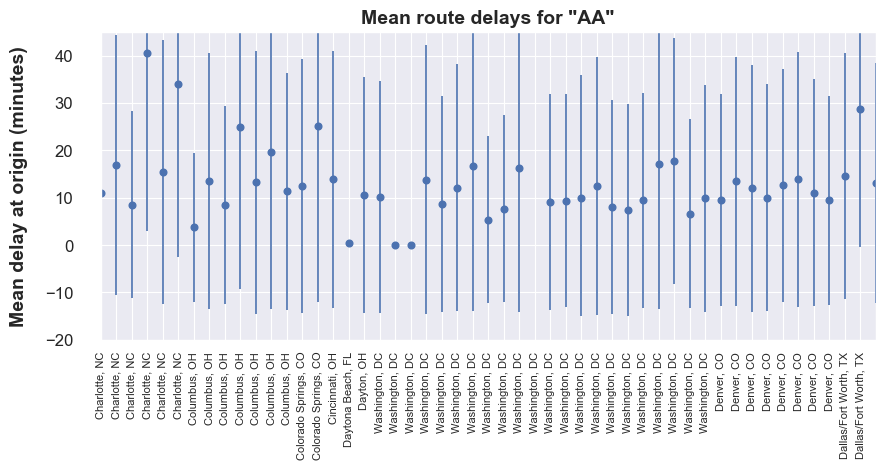

In [94]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(carrier),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 150, 200
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
#     if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

The plot contains the mean delays for `AA`, according to the city of origin and a destination city. Only the city of origin has been indicated in the plot. It can be observed that for a given airport of origin, delays fluctuate depending on the destination.  


**4. Temporal variability of delays**  

## TODO
Convert the times into datetime objects first